# XGBoost Notebook - Simple Matching

The purpose of this notebook is to use the results from the simple matching scheme and predict the slope of road links.

For run time considerations, the following code is run once and then skipped in place of reading the pickled file:

    probe_data = pd.read_csv(os.path.join(DATA_DIR, "simple_match.csv"))
    probe_data['dateTime'] = pd.to_datetime(probe_data['dateTime'])
    probe_data.to_pickle(os.path.join(DATA_DIR, 'converted_simple_match.pickle'))



In [15]:
# Imports
        
import os
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

from datetime import datetime


# Constants
DATA_DIR = "probe_data_map_matching"

link_headers = ["linkPVID", 
                "refNodeID", 
                "nrefNodeID", 
                "length", 
                "functionalClass", 
                "directionOfTravel", 
                "speedCategory", 
                "fromRefSpeedLimit", 
                "toRefSpeedLimit", 
                "fromRefNumLanes", 
                "toRefNumLanes", 
                "multiDigitized", 
                "urban", 
                "timeZone", 
                "shapeInfo", 
                "curvatureInfo", 
                "slopeInfo"]

In [2]:
# Read in the Link Data
link_data = pd.read_csv(os.path.join(DATA_DIR, "Partition6467LinkData.csv"), header=None, names=link_headers)
link_data.drop('curvatureInfo', axis=1, inplace=True)

print(link_data.shape)

link_data.head()

(200089, 16)


,linkPVID,refNodeID,nrefNodeID,length,functionalClass,directionOfTravel,speedCategory,fromRefSpeedLimit,toRefSpeedLimit,fromRefNumLanes,toRefNumLanes,multiDigitized,urban,timeZone,shapeInfo,slopeInfo
0,62007637,162844982,162809070,335.04,5,B,7,30,30,0,0,F,T,0.0,51.4965800/9.3862299/|51.4994700/9.3848799/,NaN
1,567329767,162844982,162981512,134.56,5,B,7,0,0,0,0,F,T,0.0,51.4965800/9.3862299/|51.4966899/9.3867100/|51...,NaN
2,62007648,162877732,162844982,97.01,5,B,7,30,30,0,0,F,T,0.0,51.4962899/9.3849100/|51.4965800/9.3862299/,NaN
3,78670326,162877732,163152693,314.84,5,B,7,30,30,0,0,F,T,0.0,51.4962899/9.3849100/|51.4990000/9.3836099/,NaN
4,51881672,174713859,174587951,110.17,3,B,6,50,50,2,2,F,T,0.0,53.0643099/8.7903400/45.79|53.0650299/8.791470...,0.00/-0.090|110.17/0.062


In [3]:
# how many have slope info?
link_data.dropna().shape

(53517, 16)

In [4]:
# Actually get rid of the missings
link_data.dropna(inplace=True)

In [5]:
# Read in the (Matched) Probe Data

probe_data = pd.read_csv(os.path.join(DATA_DIR, "simple_match.csv"))
probe_data['dateTime'] = pd.to_datetime(probe_data['dateTime'], format='%m/%d/%Y %I:%M:%S %p')
#probe_data.to_pickle(os.path.join(DATA_DIR, 'converted_simple_match.pickle'))

#probe_data = pd.read_pickle(os.path.join(DATA_DIR, 'converted_simple_match.pickle'))

## Quick Analysis of Simple Matching Results

Here we take a quick look to see what kind of coverage we have from the simple matching scheme. Do we match to most of the links? Very few? 

In [6]:
probe_data.shape

(3375745, 12)

In [7]:
# How many unique linkPVID's are contained in the matched probe data
print("Roughly what do the Groups look like?")
itr = 0
for i in probe_data.groupby('linkPVID').groups:
    if itr <= 5:
        print(i, probe_data.groupby('linkPVID').groups[i])
        itr += 1

print("There are {} Unique linkPVID's represented".format(len(probe_data.groupby('linkPVID').groups)))

Roughly what do the Groups look like?
51514446.0 Int64Index([1209248, 1209249, 1209972, 1735597, 2008557, 2157649, 2465899,
            2465900, 2465901, 2465902, 2676287, 2676289],
           dtype='int64')
51514498.0 Int64Index([735887, 1847541, 2184794], dtype='int64')
51514539.0 Int64Index([735883, 2459937, 2459939, 2459940, 2459941], dtype='int64')
51514549.0 Int64Index([2010729], dtype='int64')
51514619.0 Int64Index([1689192, 2466256], dtype='int64')
51514638.0 Int64Index([735879, 735926, 2466252, 2466257], dtype='int64')
There are 191082 Unique linkPVID's represented


So, 191082 Unique PVID's are covered. Given that there are roughly 200,000 links in the dataset, this level of coverage is actually quite good.

### Join to Link Data

In [8]:
joined_data = probe_data.join(link_data.set_index('linkPVID'), on='linkPVID', how='inner', lsuffix='l', rsuffix='r')


In [9]:
joined_data.head()

,sampleID,dateTime,sourceCode,latitude,longitude,altitude,speed,heading,linkPVID,direction,...,speedCategory,fromRefSpeedLimit,toRefSpeedLimit,fromRefNumLanes,toRefNumLanes,multiDigitized,urban,timeZone,shapeInfo,slopeInfo
0,3496,2009-06-12 06:12:49,13,51.496868,9.386022,200,23,339,706849300.0,B,...,6,50,50,1,1,F,T,0.0,51.4940599/9.3834099/202.91|51.4941200/9.38343...,0.00/-1.442|6.82/-1.275|15.96/-0.919
185405,288451,2009-08-19 05:51:03,13,51.492852,9.382393,200,0,212,706849300.0,B,...,6,50,50,1,1,F,T,0.0,51.4940599/9.3834099/202.91|51.4941200/9.38343...,0.00/-1.442|6.82/-1.275|15.96/-0.919
185406,288451,2009-08-19 05:51:08,13,51.492875,9.382403,200,2,230,706849300.0,B,...,6,50,50,1,1,F,T,0.0,51.4940599/9.3834099/202.91|51.4941200/9.38343...,0.00/-1.442|6.82/-1.275|15.96/-0.919
185407,288451,2009-08-19 05:51:13,13,51.492911,9.382495,200,0,214,706849300.0,B,...,6,50,50,1,1,F,T,0.0,51.4940599/9.3834099/202.91|51.4941200/9.38343...,0.00/-1.442|6.82/-1.275|15.96/-0.919
202731,3496,2009-06-12 06:12:49,13,51.496868,9.386022,200,23,339,706849300.0,B,...,6,50,50,1,1,F,T,0.0,51.4940599/9.3834099/202.91|51.4941200/9.38343...,0.00/-1.442|6.82/-1.275|15.96/-0.919


In [10]:
print("And now after the join and NA removal, we have {} rows of data".format(joined_data.shape[0]))

And now after the join and NA removal, we have 1631245 rows of data


## Model Setup

Here we want to build an ML Model to predict the slope of a link given some gps probe data. In order to do that we'll use the average slope of the link as the target and (a subset) of the rest of the columns of data as features for the model to predict it.

We opt to use XGBoost for a couple reasons:

First, it is a tree-based model which we think is well-suited to the lat/lon features. While we are doing a _regression_ model, we do not believe that a linear regression is the best tool for it since latitude and longitude, while real-valued, are not truly ordinal features well-suited to linear (OLS) modeling. On the other hand, tree-based (in particular boosted tree-based) models allow us to learn a complex topographical map over these features because of different split points.

Second, it is stable, well-developed and highly parallelizable which is allows us to scale to large datasets. This is appropriate because we have 3.3 million probe points.

Finally, XGBoost is a favorite among Data Scientists and Kaggle Competition winners due to its often first-class performance without requiring as much data, maintenance, or computing resources as neural networks. And, since we are not interested in automatic feature extraction such as one might attempt with Deep Learning, we think that XGBoost is a good fit.

## Feature Engineering

However, that doesn't mean that we aren't interested in creating new features. We think that there could be a lot of value in features that take the sequence of probe points (the trajectory) into account. These rollup features are things like distance traveled since last point, change in speed, change in elevation, sliding window estimates of slope, etc.

They are computed below.

In [11]:
def rolling_diff(df):
    return df[-1] - df[0]

cleaned_joined_data = joined_data.dropna()

cleaned_joined_data['avg_link_slope'] = cleaned_joined_data['slopeInfo'].apply(lambda x: np.mean([float(i.split('/')[1]) for i in x.split('|')]))

gdf = cleaned_joined_data.groupby('sampleID')
cleaned_joined_data['delta_elevation'] = gdf['altitude'].apply(lambda x: x.rolling(2, min_periods=2).apply(rolling_diff)).reset_index(0, drop=True)
cleaned_joined_data['delta_latitude'] = gdf['latitude'].apply(lambda x: x.rolling(2, min_periods=2).apply(rolling_diff)).reset_index(0, drop=True)
cleaned_joined_data['delta_longitude'] = gdf['longitude'].apply(lambda x: x.rolling(2, min_periods=2).apply(rolling_diff)).reset_index(0, drop=True)
cleaned_joined_data['delta_speed'] = gdf['speed'].apply(lambda x: x.rolling(2, min_periods=2).apply(rolling_diff)).reset_index(0, drop=True)
cleaned_joined_data['rolling_slope'] = cleaned_joined_data['delta_elevation'] / np.sqrt(cleaned_joined_data['delta_latitude'] ** 2 + cleaned_joined_data['delta_longitude'] ** 2)
cleaned_joined_data['rolling_acc'] = cleaned_joined_data['delta_speed'] / np.sqrt(cleaned_joined_data['delta_latitude'] ** 2 + cleaned_joined_data['delta_longitude'] ** 2)

cleaned_joined_data = cleaned_joined_data.dropna()




In [20]:
subset = cleaned_joined_data[[#'sampleID',
                   #'dateTime',
                   'altitude',
                    'latitude', 
                    'longitude',
                   'speed', 
                   #'heading', 
                   'length',
                   #'functionalClass',
                   'fromRefSpeedLimit', 
                   #'toRefSpeedLimit', 
                   'fromRefNumLanes', 
                   #'toRefNumLanes',
                    #'delta_elevation',
                    'delta_speed',
                    'rolling_slope',
                   'avg_link_slope']]

print(subset.shape)
import sklearn
train, test = sklearn.cross_validation.train_test_split(subset, test_size = 0.2, random_state=1)


dtrain = xgb.DMatrix(train.values[:,:-1], train.values[:,-1])
dtest = xgb.DMatrix(test.values[:,:-1], test.values[:,-1])
param = {'max_depth':10, 'eta':0.3, 'silent':1, "objective": "reg:linear", "booster":"gbtree" }
param['nthread'] = 48
param['eval_metric'] = 'rmse'
evallist  = [(dtest,'eval'), (dtrain,'train')]
num_round = 1000
bst = xgb.train( param, dtrain, num_round, evallist, early_stopping_rounds=10)


(759143, 10)
[0]	eval-rmse:1.00154	train-rmse:0.996991
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[1]	eval-rmse:0.919175	train-rmse:0.914479
[2]	eval-rmse:0.881008	train-rmse:0.876026
[3]	eval-rmse:0.847277	train-rmse:0.841743
[4]	eval-rmse:0.825367	train-rmse:0.819839
[5]	eval-rmse:0.799023	train-rmse:0.792744
[6]	eval-rmse:0.78779	train-rmse:0.781124
[7]	eval-rmse:0.77625	train-rmse:0.768939
[8]	eval-rmse:0.764456	train-rmse:0.756493
[9]	eval-rmse:0.74255	train-rmse:0.733098
[10]	eval-rmse:0.719245	train-rmse:0.708862
[11]	eval-rmse:0.712048	train-rmse:0.701328
[12]	eval-rmse:0.709749	train-rmse:0.698848
[13]	eval-rmse:0.694367	train-rmse:0.681708
[14]	eval-rmse:0.689797	train-rmse:0.677063
[15]	eval-rmse:0.681908	train-rmse:0.668718
[16]	eval-rmse:0.667904	train-rmse:0.653419
[17]	eval-rmse:0.665392	train-rmse:0.650674
[18]	eval-rmse:0.661916	train-rmse:0.646846
[19]	eval-rmse:0.657

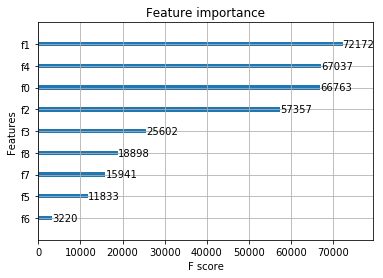

In [21]:
xgb.plot_importance(bst)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


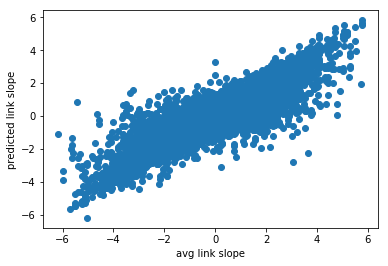

In [22]:
preds = bst.predict(dtest)
zipped_preds = test
zipped_preds['preds'] = preds

plt.figure()
plt.scatter(zipped_preds['avg_link_slope'], zipped_preds['preds'])
plt.xlabel('avg link slope')
plt.ylabel('predicted link slope')
plt.show()